# AutoML for Images - Retail Shelf Classification - Calling CV model

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/shelves.jpg?raw=true" width=500>

In [28]:
#!pip install librosa
#!pip install pymsteams
#!pip install emoji
#!pip install twilio

In [29]:
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core.webservice import Webservice
import requests
import json
import matplotlib.pyplot as plt 
import cv2
import urllib
import time
from azure.cognitiveservices.speech import AudioDataStream, SpeechConfig, SpeechSynthesizer, SpeechSynthesisOutputFormat
from azure.cognitiveservices.speech.audio import AudioOutputConfig
import azure.cognitiveservices.speech as speechsdk
import librosa, librosa.display, IPython.display as ipd
import pymsteams
import smtplib
from email.message import EmailMessage
import emoji

In [30]:
import datetime
dt = datetime.datetime.now()
today = dt.strftime("%Y-%m-%d %H:%M:%S")
print(today)

2021-12-13 16:41:09


In [31]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [32]:
ws = Workspace.from_config()
print("Azure ML workspace:", ws.name, "\nAzure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlvision 
Azure ML resource group: azuremlvision-rg


## Computer vision model to use

In [33]:
service = Webservice(workspace=ws, name='automlcv-shelf')
print(service.scoring_uri)
print(service.swagger_uri)

http://20.93.27.173:80/api/v1/service/automlcv-shelf/score
http://20.93.27.173:80/api/v1/service/automlcv-shelf/swagger.json


In [34]:
primary, secondary = service.get_keys()

In [35]:
# URL for the web service
scoring_uri = service.scoring_uri
# If the service is authenticated, set the key or token
key = primary

## Image to analyze

In [36]:
#imagefile = '../beverages/images/dataset/Beverages/Test/Valid/IMG_4095.JPG'
imagefile = '../beverages/images/dataset/Beverages/Test/Invalid/IMG_4202.JPG'

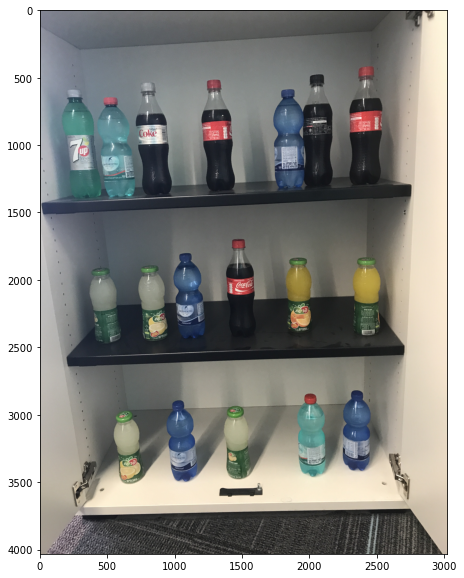

In [37]:
img = cv2.imread(imagefile)
h, w, c = img.shape
plt.figure(figsize=(10,10)) 
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

## Results

In [38]:
%%time
input_data = open(imagefile, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, input_data, headers=headers)
print(resp.text)

{"filename": "/tmp/tmp8kbjlztx", "probs": [0.9998847246170044, 0.00011526460730237886], "labels": ["Invalid", "Valid"]}

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 634 ms


In [39]:
predictions = json.loads(resp.text) # Loadind the predictions from the computer vision model    
predictions

{'filename': '/tmp/tmp8kbjlztx',
 'probs': [0.9998847246170044, 0.00011526460730237886],
 'labels': ['Invalid', 'Valid']}

In [40]:
probs = predictions['probs']
labels = predictions['labels']

In [41]:
if probs[0] >= probs[1]:
    max = 0
elif probs[0] < probs[1]:
    max = 1

In [42]:
print('\033[1;31;34mPrediction:', labels[max], 'with confidence =', round(probs[max], 3))

Prediction: Invalid with confidence = 1.0


## Speech to Text

In [43]:
azureSTT_key = '90874240bf4146ffacf843faed7e7a84'
azureSTT_region = 'eastus'

In [44]:
LanguageToUse = 'EN'

audiofile = 'beverage_' + LanguageToUse + '.wav'
if LanguageToUse == 'FR':
    MSG = "La prédiction est la suivante : l'étagère " + str(labels[max]) + ' avec une confiance de ' + str(round(probs[max], 3)*100) + '%'
    LANGUAGE = "fr-FR"   
if LanguageToUse == 'EN':
    MSG = "The prediction is : the shelf is " + str(labels[max]) + ' with a confidence of ' + str(round(probs[max], 3)*100) + '%'
    LANGUAGE = "en-EN"

In [45]:
speech_config = SpeechConfig(subscription=azureSTT_key, region=azureSTT_region)
speech_config.speech_synthesis_language = LANGUAGE # Language to use

audio_config = AudioOutputConfig(filename=audiofile)
speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config)
synthesizer = SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config,)

synthesizer.speak_text_async(MSG) # Text to Speech using the MSG text

print("========= Azure Text to Speech results =========\n")
from os.path import getsize
sizefile=getsize(audiofile)
print('File is:', audiofile)
print()
print(f"Size of '{audiofile}' file = {sizefile}")
print("Audio file date: %s" % time.ctime(os.path.getmtime(audiofile)))

samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = None)
duration = len(samples) / sampling_rate
print("Audio file duration =", round(duration, 3), 'seconds')

========= Azure Text to Speech results =========

File is: beverage_EN.wav

Size of 'beverage_EN.wav' file = 164446
Audio file date: Mon Dec 13 16:41:51 2021
Audio file duration = 5.138 seconds


In [46]:
from IPython.display import Audio
Audio(audiofile)

In [47]:
print('\033[1;31;34m', MSG)

 The prediction is : the shelf is Invalid with a confidence of 100.0%


## Sending the results to TEAMS if the result is invalid

In [48]:
from datetime import datetime
teams="https://microsoft.webhook.office.com/webhookb2/cc71dfbf-6be5-4ff5-b3b2-31fc995339f8@72f988bf-86f1-41af-91ab-2d7cd011db47/IncomingWebhook/ba813ea64f9243d7b47f615e0d2c6f2c/ff4137a8-2d37-4ee7-8675-9876eba469ce"

if labels[max] == 'Invalid':
    now = datetime.now()
    TeamsMSG = '[' + str(now) + '] ' + MSG
    print('Message to send to Teams:\n', TeamsMSG)
    myTeamsMessage = pymsteams.connectorcard(teams)
    myTeamsMessage.text(TeamsMSG)
    #myTeamsMessage.printme()
    print("Sent message to Teams...")
    myTeamsMessage.send()
    print()
    print(emoji.emojize(':thumbs_up:'), 'Done')

if labels[max] == 'Valid':
    print("No message to send to TEAMS because the shelf is valid.")

Message to send to Teams:
 [2021-12-13 16:41:59.647548] The prediction is : the shelf is Invalid with a confidence of 100.0%
Sent message to Teams...

👍 Done


## Send SMS is the shelf is invalid

In [49]:
if labels[max] == 'Invalid':
    # Sending the licence plate number by SMS
    from twilio.rest import Client

    print("Sending SMS...")

    # SMS Twilio account details
    twilio_account_sid = 'ACb13ecc78dad72e6a31c2b269bae401fe'
    twilio_auth_token = '4e9839cb4a8ada798fbf96cdad416bec'
    twilio_source_phone_number = '+14708239698'

    client = Client(twilio_account_sid, twilio_auth_token)

    smstext = TeamsMSG
    print(smstext)

    message = client.messages.create(body=smstext, from_=twilio_source_phone_number, to="+33762879986")
    print(emoji.emojize(':thumbs_up:'), 'SMS sent!')

if labels[max] == 'Valid':
    print("No SMS to send because the shelf is valid.")

Sending SMS...
[2021-12-13 16:41:59.647548] The prediction is : the shelf is Invalid with a confidence of 100.0%
👍 SMS sent!


## Email

In [50]:
# Retrieve email parameters from email_parameters.py
import email_parameters as emailparams
EMAIL_SENDER = emailparams.EMAIL_SENDER
EMAIL_PASSWORD = emailparams.EMAIL_PASSWORD
EMAIL_RECEIVER = emailparams.EMAIL_RECEIVER

In [51]:
if labels[max] == 'Invalid':
    import datetime
    emaildate = datetime.datetime.today().strftime ('%d-%b-%Y %H:%M:%S')
    msg = EmailMessage()

    msg['Subject'] = '[Alert] The shelf is Invalid ' + str(emaildate)
    msg['From'] = EMAIL_SENDER 
    msg['To'] = EMAIL_RECEIVER 

    msg.set_content(MSG)

    attachedfile1 = imagefile
    attachedfile2 = audiofile

    with open(attachedfile1, 'rb') as pdf:
        msg.add_attachment(pdf.read(), maintype='application', subtype='octet-stream', filename=pdf.name)

    with open(attachedfile2, 'rb') as pdf:
        msg.add_attachment(pdf.read(), maintype='application', subtype='octet-stream', filename=pdf.name)
    
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        print(emaildate, "Sending email...")
        smtp.login(EMAIL_SENDER, EMAIL_PASSWORD) 
        smtp.send_message(msg)
        print(emoji.emojize(':thumbs_up:'), 'Done.')

13-Dec-2021 16:42:04 Sending email...
👍 Done.


> End